In [227]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [228]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel

In [229]:
import calendar
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [230]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [231]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [232]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [233]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [234]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [235]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [236]:
inspector = inspect(engine)

In [237]:
# Get a list of column names and types for "station"
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [238]:
# Get a list of column names and types for "measurement"
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

## Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

In [239]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement).order_by(Measurement.date.desc()).first().date
first_date = (pd.to_datetime(last_date) - timedelta(days=365)).date()
print(f'Last Date Recorded: {last_date}\nDate one year before: {first_date}')

Last Date Recorded: 2017-08-23
Date one year before: 2016-08-23


In [240]:
# Perform a query to retrieve the data and precipitation scores
datas = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= first_date)

In [268]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(datas, columns=['Dates', 'Precipitations'])
df.set_index('Dates', inplace=True)

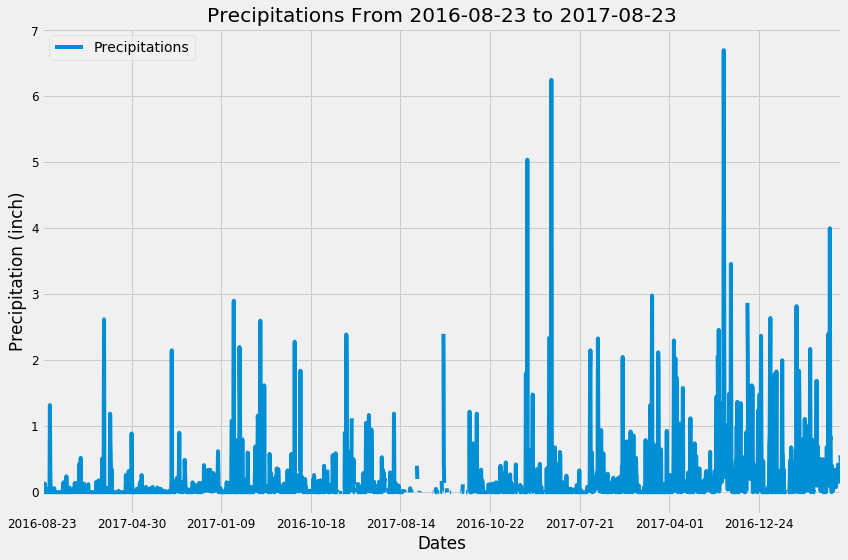

In [271]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot.line(title=f"Precipitations From {first_date} to {last_date}", fontsize = 12, figsize=(12,8))
plt.ylabel('Precipitation (inch)')
plt.tight_layout()
plt.savefig("Figures/precipitations_one_year.png")
plt.show()

In [243]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitations
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

* Design a query to calculate the total number of stations.

In [244]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(Measurement.station).\
    group_by(Measurement.station).count()
print("{} stations are available in this dataset.".format(count_stations))

9 stations are available in this dataset.


* Design a query to find the most active stations.
    * List the stations and observation counts in descending order.

In [245]:
# Design a query to get the stations and their observations count
active_stations = session.query(Station.name, Measurement.station, func.count(Measurement.station)).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()                                 

In [246]:
# Save the query results as a Pandas DataFrame and set the index to the station ID column
active_df = pd.DataFrame(active_stations, columns=["Station Name", "Station ID", "Observations Count"])
active_df.set_index("Station ID", inplace=True)
active_df

,Station Name,Observations Count
Station ID,,
USC00519281,"WAIHEE 837.5, HI US",2772
USC00519397,"WAIKIKI 717.2, HI US",2724
USC00513117,"KANEOHE 838.1, HI US",2709
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
USC00517948,"PEARL CITY, HI US",1372
USC00518838,"UPPER WAHIAWA 874.3, HI US",511


* Which station has the highest number of observations?

In [247]:
# Design a query to find the most active station
most_active= session.query(Station.name, Measurement.station, func.count(Measurement.station)).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).first()  

In [248]:
print("The station {} (ID:{}) has the highest number of observations with {} observations.".\
      format(most_active[0], most_active[1], most_active[2]))

The station WAIHEE 837.5, HI US (ID:USC00519281) has the highest number of observations with 2772 observations.


* For the station with the highest number of observations, calculate:
    * lowest, highest and average temperature recorded

In [249]:
# Design a query to get the lowest, highest and average temperature recorded for the most active station
query_temp = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active[1]).all()

records = ["lowest", "average", "highest"]
for results in query_temp:
    for i in range(len(results)):
        print(f"The {records[i]} temperature recorded is {results[i]:.1f}° F")

The lowest temperature recorded is 54.0° F
The average temperature recorded is 71.7° F
The highest temperature recorded is 85.0° F


* Design a query to retrieve the last 12 months of temperature observation data (tobs) for the same station

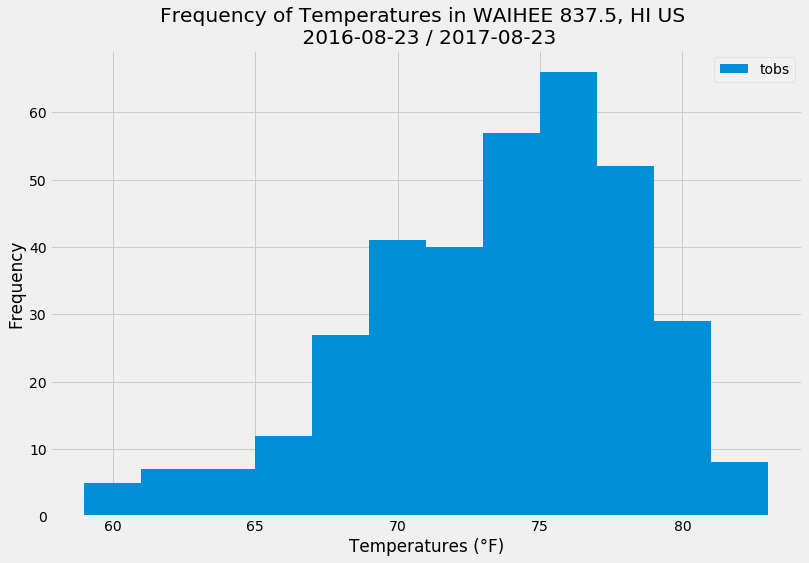

In [272]:
# Query the last 12 months of temperature observation data for the station with the highest number of temperature observations.
twelve_months = session.query(Measurement.tobs).\
    filter((Measurement.station == most_active[1]), (Measurement.date > first_date)).all()

# Convert the query results in a DataFrame
df_twelve = pd.DataFrame(twelve_months)

# Plot the results as a histogram
df_twelve.plot.hist(bins=12, title=f"Frequency of Temperatures in {most_active[0]} \n {first_date} / {last_date}",
                   figsize=(12,8))
plt.xlabel('Temperatures (°F)')
plt.savefig("Figures/Frequency_temperatures_oneyear.png")
plt.show()

## Temperature Analysis I

Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

In [251]:
def monthly_list(month_number):
    """Monthly List.
    
    Args:
        month_number (str): A date string in the format '%m'
        
    Returns:
        A list of temperatures for this month at all stations across all available years in the dataset.
    
    """
    return session.query(Measurement.tobs).\
                         filter(func.strftime("%m", Measurement.date) == month_number).all()

In [253]:

while True:
    try:
        number_month1 = input("First month in format MM ?   ")
        print(f'Month of {calendar.month_name[int(number_month1)]} selected')
        number_month2 = input("Second month in format MM ?   ")
        print(f'Month of {calendar.month_name[int(number_month2)]} selected')
        break
    except (ValueError, IndexError):
        print(f'Input {number_month1} does not match format MM (e.g. 01 for January)')


means_month1 = np.mean(monthly_list(number_month1))
means_month2 = np.mean(monthly_list(number_month2))
print(f"The average temperature for {calendar.month_name[int(number_month1)]} is {means_month1:.1f} \
and {means_month2:.1f} for {calendar.month_name[int(number_month2)]}.")


First month in format MM ?   07
Month of July selected
Second month in format MM ?   08
Month of August selected
The average temperature for July is 76.1 and 76.4 for August.


In order to determine whether the difference in the means is statistically significant, the unpaired t-test (Student t-test) has been chosen. Even if we have records from the same stations, we don't have the same number of records these two months.

In [254]:
# t-test
(t_stat, p) = ttest_ind(monthly_list(number_month1), monthly_list(number_month2), equal_var=False)
print(f't-stat = {t_stat} ; p = {p}')
if p < 0.001:
    print(f"The differences of means between {calendar.month_name[int(number_month1)]} \
and {calendar.month_name[int(number_month2)]} ARE statistically highly significant.")
    
elif p < 0.05:
    print(f"The differences of means between {calendar.month_name[int(number_month1)]} \
and {calendar.month_name[int(number_month2)]} ARE statistically significant.")
    
else:
    print(f"The differences of means between {calendar.month_name[int(number_month1)]} \
and {calendar.month_name[int(number_month2)]} ARE NOT statistically significant.")

t-stat = [-2.79577888] ; p = [0.00520735]
The differences of means between July and August ARE statistically significant.


## Temperature Analysis II

The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

Plot the min, avg, and max temperature from your previous query as a bar chart.


Use the average temperature as the bar height.
Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).




In [255]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [262]:
while True:
    try:
        start_trip = input("Trip start in MM/DD/YYYY format?   ")
        
        start_trip = (pd.to_datetime(start_trip)).date()
        
        if start_trip > dt.date.today() :
            print('Nice choice!')
            break
        else:
            print('The date has passed')
    except ValueError:
        print(f'time data {start_trip} does not match format MM/DD/YYYY')

while True:
    try:
        number_days = int(input("How many days?   "))
        if 3 <= number_days <= 15:
            print('Enjoy!')
            break
        else:
            print('Make sure that your vacation range is approximately 3-15 days total')
    except ValueError:
        print(f'{number_days} is not a digit - please try again.')

end_trip = (start_trip + timedelta(days=number_days))

start_trip1 = start_trip.strftime("%a %d %b, %Y")
end_trip1 = end_trip.strftime("%a %d %b, %Y")
print(f"You plan to go to Honolulu, Hawaii from {start_trip1} to {end_trip1}")

Trip start in MM/DD/YYYY format?   23062020
time data 23062020 does not match format MM/DD/YYYY
Trip start in MM/DD/YYYY format?   07/14/2021
Nice choice!
How many days?   8
Enjoy!
You plan to go to Honolulu, Hawaii from Wed 14 Jul, 2021 to Thu 22 Jul, 2021


In [263]:
counter_year = 1
while (pd.to_datetime(end_trip)- timedelta(days= counter_year*365.25) > (pd.to_datetime(last_date))):

    #counter + 1
    counter_year +=1
else:
    start_date = (pd.to_datetime(start_trip)- timedelta(days=counter_year*365.25)).date()
    end_date = (pd.to_datetime(end_trip)- timedelta(days=counter_year*365.25)).date()

In [264]:
print(f"Period used to query will be: {start_date} to {end_date}")

Period used to query will be: 2017-07-14 to 2017-07-22


In [265]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(f"Between {start_date} and {end_date}:")
for results in calc_temps(start_date, end_date):
    for i in range(len(results)):
        print(f"The {records[i]} temperature recorded is {results[i]:.1f}° F")

Between 2017-07-14 and 2017-07-22:
The lowest temperature recorded is 72.0° F
The average temperature recorded is 78.5° F
The highest temperature recorded is 83.0° F


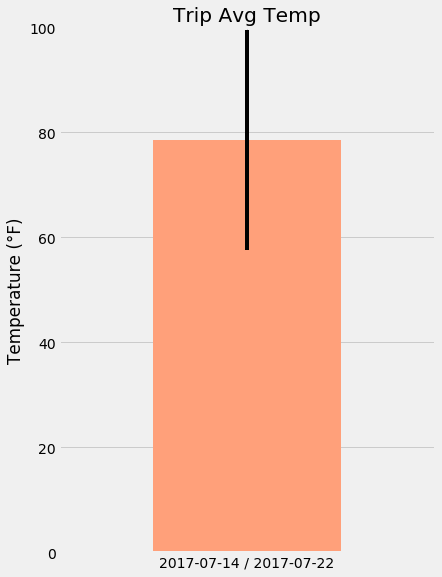

In [266]:
# Plot the results from your previous query as a bar chart. 
x = (f"{start_date} / {end_date}")

#plt.subplots()
plt.figure(figsize=(6,9))
plt.bar(x, results[1], width=0.5, align='center', yerr = (tmax-tmin), color='lightsalmon')
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (°F)')
plt.xlim(-0.5,0.5)
plt.ylim(0,100)

#plt.tight_layout()
plt.show()

## Daily Rainfall Average


Calculate the rainfall per weather station using the previous year's matching dates.
Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.
You are provided with a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.
Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.
Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
Use Pandas to plot an area plot (stacked=False) for the daily normals.

In [63]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, Station.latitude, 
   Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
rainfall = session.query(*sel).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


In [77]:
rainfall_df = pd.DataFrame(rainfall, columns=['Station ID', 'Station Name', 'Latitude', 'Longitude',
                                              'Elevation', f'Precipitations {start_date} / {end_date}'])
rainfall_df.set_index(['Station ID'])

,Station Name,Latitude,Longitude,Elevation,Precipitations 2017-02-03 / 2017-02-11
Station ID,,,,,
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,6.84
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.34
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,3.33
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.23
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.52
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.82
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


## Optional Challenge Assignment

In [273]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
        
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [274]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
#start_date = pd.to_datetime(start_date)
#end_date =  pd.to_datetime(end_date)
# Use the start and end date to create a range of dates
days_trip = 1 + (end_date - start_date).days

# Stip off the year and save a list of %m-%d strings
date_y_m_d = []
date_m_d = []
for i in range(days_trip):
    dates_trip = ((start_date) + timedelta(days=i))
    date_y_m_d.append(dates_trip.strftime("%Y-%m-%d"))
    date_m_d.append(dates_trip.strftime("%m-%d"))
    
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []


for dates in date_m_d:
    print(daily_normals(dates))
    normals.append(daily_normals(dates))
normals


[(61.0, 76.2280701754386, 82.0)]
[(68.0, 76.2542372881356, 82.0)]
[(70.0, 76.34482758620689, 83.0)]
[(70.0, 76.30188679245283, 83.0)]
[(72.0, 76.63793103448276, 83.0)]
[(68.0, 75.89090909090909, 83.0)]
[(69.0, 75.46296296296296, 82.0)]
[(69.0, 76.9245283018868, 83.0)]
[(69.0, 75.78846153846153, 81.0)]


[[(61.0, 76.2280701754386, 82.0)],
 [(68.0, 76.2542372881356, 82.0)],
 [(70.0, 76.34482758620689, 83.0)],
 [(70.0, 76.30188679245283, 83.0)],
 [(72.0, 76.63793103448276, 83.0)],
 [(68.0, 75.89090909090909, 83.0)],
 [(69.0, 75.46296296296296, 82.0)],
 [(69.0, 76.9245283018868, 83.0)],
 [(69.0, 75.78846153846153, 81.0)]]

In [275]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [276]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin = [(value[0][0]) for value in normals]
tavg = [(value[0][1]) for value in normals]
tmax = [(value[0][2]) for value in normals]

#for value in normals:
 #   tmin = (value[0][0])
  #  tavg = value[0][1]
   # tmax = value[0][2]
    
print(tmin, tavg, tmax)

[61.0, 68.0, 70.0, 70.0, 72.0, 68.0, 69.0, 69.0, 69.0] [76.2280701754386, 76.2542372881356, 76.34482758620689, 76.30188679245283, 76.63793103448276, 75.89090909090909, 75.46296296296296, 76.9245283018868, 75.78846153846153] [82.0, 82.0, 83.0, 83.0, 83.0, 83.0, 82.0, 83.0, 81.0]


In [277]:
df = pd.DataFrame({"Date": date_y_m_d, "tmin": tmin, "tavg": tavg, "tmax": tmax}).set_index("Date")
#df = df.set_index("Date")
df

,tmin,tavg,tmax
Date,,,
2017-07-14,61.0,76.228070,82.0
2017-07-15,68.0,76.254237,82.0
2017-07-16,70.0,76.344828,83.0
2017-07-17,70.0,76.301887,83.0
2017-07-18,72.0,76.637931,83.0
2017-07-19,68.0,75.890909,83.0
2017-07-20,69.0,75.462963,82.0
2017-07-21,69.0,76.924528,83.0
2017-07-22,69.0,75.788462,81.0


In [278]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


Text(0.5, 1.0, 'Evolution of temperatures 2017-07-14 / 2017-07-22')

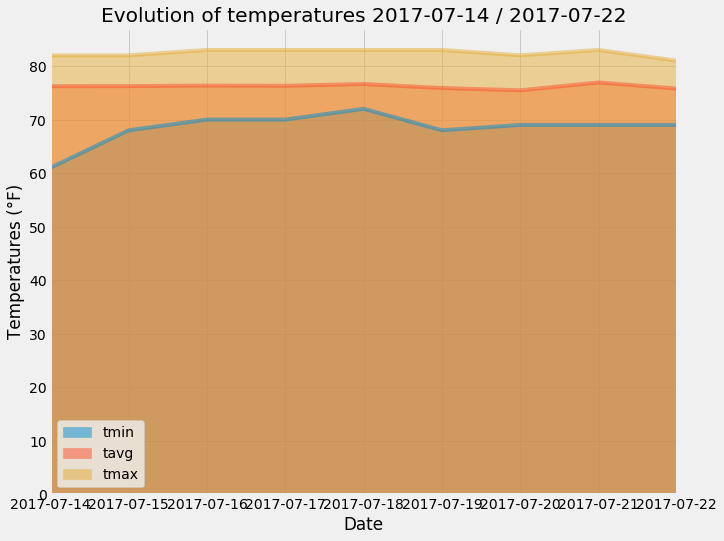

In [279]:
# Plot the daily normals as an area plot with `stacked=False`

df.plot.area(stacked=False, figsize=(10,8))
plt.ylabel('Temperatures (°F)')
plt.title(f'Evolution of temperatures {start_date} / {end_date}')